In [1]:
import os
import time
import sys
import bisect
import pickle

import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage import transform

from scipy import stats
import scipy.signal as signal
import scipy.interpolate as interpolate
from scipy import ndimage as nd
from skimage import transform
from tqdm.notebook import tqdm

import isx

In [2]:
def get_background_images(in_movie, seg_times, n_background_frames = 500, fps = 20):
    #
    # 
    #
    #
    #
    
    print('Background detection assuming {}fps video\n'.format(fps))
    
    rng = np.random.default_rng()
    
    vid = cv2.VideoCapture(in_movie)
    num_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    vid_size = [int(vid.get(4)), int(vid.get(3))]
    
    # convert segments to indices and add start/stop frames:
    seg_times = [int(i*fps) for i in seg_times]
    seg_times.append(num_frames)
    seg_times.insert(0, 0)
    seg_idx = [[i, j] for i,j in zip(seg_times[:-1], seg_times[1:]) ]
    
    out_list = []
    
    # build background image for each segment:
    for seg in tqdm(seg_idx):
        framevect = np.unique(rng.integers(seg[0], seg[1], int(n_background_frames * 2)))[:n_background_frames] # draw n_background_frames without replacement
        background_dat = np.zeros( (len(framevect), vid_size[0], vid_size[1]) ).astype('uint8')
        #vid = cv2.VideoCapture(vid_fn)
        #bidx = 0
        for bidx,i in enumerate(framevect):
            vid.set(1, i)
            theframe = vid.read()[1]
            grayscale = cv2.cvtColor(theframe,cv2.COLOR_BGR2GRAY).astype('uint8')
            #grayscale = (np.sum(theframe,axis=2)/3).astype('uint8')
            background_dat[bidx] = grayscale
            #bidx += 1        

        #background_frame = np.median(background_dat, axis=0)
        out_list.append(np.median(background_dat, axis=0))
        

    
    vid.release()
    return out_list

###################################################################################
###################################################################################

def movie_com(in_movie, background_movie, seg_times, filt_size = 10, ds_fact = 4, pthresh = 99, fps = 20):
    #
    #
    #

    vid = cv2.VideoCapture(in_movie)
    num_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_range = list(range(num_frames))

    # initialize output:
    com_vect = np.zeros((len(frame_range),2)).astype('int32')
    
    seg_times = [int(i*fps) for i in seg_times]
    seg_times.append(num_frames)
    seg_times.insert(0, 0)
    seg_idx = [[i, j] for i,j in zip(seg_times[:-1], seg_times[1:]) ]
    
    movie_epochs = [np.arange(i[0],i[1]) for i in seg_idx]
    print(np.shape(movie_epochs))

    for framei in tqdm(range(len(frame_range))):
        vid.set(1, framei)
        theframe = vid.read()[1]

        background_frame_ds = transform.downscale_local_mean(background_movie[np.argwhere([framei in i for i in movie_epochs])[0][0]], (ds_fact, ds_fact))
        grayscale = transform.downscale_local_mean( cv2.cvtColor(theframe,cv2.COLOR_BGR2GRAY).astype('uint8'), (ds_fact,ds_fact))

        bg_subtracted = grayscale - background_frame_ds
        bg_subtracted[bg_subtracted > np.percentile(bg_subtracted, 100-pthresh)] = 0
        bg_subtracted[bg_subtracted > 0] = 255

        center_of_mass = nd.center_of_mass(nd.maximum_filter(bg_subtracted, int(filt_size / ds_fact )))
        
        if sum(np.isnan(center_of_mass)):
            com_vect[framei] = com_vect[framei -1]
        else:
            com_vect[framei] = [i for i in center_of_mass]

    vid.release()
    return com_vect

###################################################################################
###################################################################################


    


In [3]:
def apply_butterworth(sig,cutoff,fs,filt_order,filt_type):
    #
    # applies zero-phase digital butterworth filter to data in sig
    # if sig is a matrix, data in its columns are filtered
    #
    # cutoff is filter's critical frequency in Hz, or n=2 tuple of freqs for bandpass filters
    # fs is sampling rate
    # filt_order is integer filter order
    # filt_type is 'lowpass','highpass', 'bandpass', or 'bandstop' 
    # 
    # returns filtered signal 
    #
    
    nyq = 0.5 * fs
    norm_cutoff =cutoff/nyq
    b,a = signal.butter(filt_order,norm_cutoff,btype=filt_type,analog=False)
    
    if sig.ndim > 1:
        filt_sig = signal.filtfilt(b,a,sig,axis=1)
    elif sig.ndim == 1:
        filt_sig = signal.filtfilt(b,a,sig)
    else:
        filt_sig = []
    
    return filt_sig

def median_filter_matrix(inmtx,winsize=3):
    #
    # median filters each column of matrix with kernal width = winsize
    #
    # returns filtered matrix
    #
    
    filtmtx = np.zeros_like(inmtx)
    
    for i in range(inmtx.shape[0]):
        filtmtx[i] = signal.medfilt(inmtx[i],winsize)
    return filtmtx

def otsu(x):
    # returns threshold estimated via Otsu's method
    # x needs to be 1-d list
    nbins = 500
    logx = np.log(x)
    logx = np.asarray([i for i in logx if np.isfinite(i)])
    
    minim = min(logx)
    maxim = max(logx)
    logx = (logx-minim)/(maxim-minim)
    
    xhist = np.histogram(logx, bins=nbins)
    xbins = xhist[1]
    xbins = xbins[1:]
    xcounts = xhist[0] / sum(xhist[0])

    maximum = 0
    thresh = 0
    
    for t in range(len(xcounts)):
        w0 = sum(xcounts[:t])
        w1 = sum(xcounts) - w0
        if w0 == 0 or w1 == 0:
            #print('continuing...')
            continue
        mu0 = sum(xbins[:t]*xcounts[:t]) / w0
        mu1 = sum(xbins[t:]*xcounts[t:]) / w1
        sigB = w0 * w1 * ((mu0 - mu1) * (mu0 - mu1))
        if sigB >= maximum:
            maximum = sigB
            thresh = xbins[t]
    
    th = thresh*(maxim-minim) + minim
    th = np.exp(th)
    #th = np.power(10,th)
    thresh = th

    return thresh


def register_signals(ref_time,in_dat,in_time):
    #
    # Direct alignment of signals that were sampled at diffrent rates
    # resamples in_dat to len(ref_time) by aligning timestamps in ref_time with timestamps in in_time
    # in_time is vector of timestamps for data in in_dat
    #
    # len(ref_time) < len(in_time)
    #
    #
    
    resamp_dat = np.zeros_like(ref_time)

    for t in range(len(ref_time)):
        dat = in_dat[bisect.bisect(in_time,ref_time[t])-1]
        resamp_dat[t] = dat
    return resamp_dat
    
def segment(x,thresh):
    # returns onsets & offset indices of impulses that exceed thresh in vector x
    xsub = x - thresh
    xdiff = (xsub[:-1]*xsub[1:]) < 0
    edges = np.where(xdiff == 1) # indices at onsets/offsets
    edges = list(edges[0])
    
    x[0:5] = 0
    
    if np.mean(np.diff(x[edges[0]-2:edges[0]+2])) < 0: # delete first impulse if offset
        print('first impulse is offset')
        edges.pop(0)
    if np.mean(np.diff(x[edges[-1]-2:edges[-1]+2])) > 0: # delete last impulse if onset
        print('last impulse is onset')
        edges.pop(-1)
    onsets = edges[0::2]
    offsets = edges[1::2]
    
    if len(onsets) > len(offsets):
        onsets.pop(-1)
    
    return [onsets,offsets]

def extractsegments(x,onsets,offsets,win):
    # returns list of slices from x[onsets[i]-win:offsets[i]+win]
    
    win = int(win)
    if onsets[0] - win < 1 or offsets[-1] > len(x):
        print('Edge Syllable')
        return []
    else:
        segs = [x[onsets[i]-win : offsets[i]+win] for i in range(len(onsets))]
        return segs
    
def filtersegments(segs,minlen,maxlen):
    # deletes elements of segs with maxlen < len() < minlen
    return [i for i in segs if len(i) > minlen and len(i) < maxlen]
    
def twoaxis(axname,lwidth=2):
    #
    # formats axes by setting axis thickness & ticks to lwidth and clearing top/right axes
    #
    #
    axname.spines['bottom'].set_linewidth(lwidth)
    axname.tick_params(width=lwidth)
    axname.spines['left'].set_linewidth(lwidth)
    axname.spines['top'].set_linewidth(0)
    axname.spines['right'].set_linewidth(0)
    
# functions for object detection:

def subtract_img_background(input_img):
    #
    # Uses pixel dilation to adaptively filter nonuniform background from objects in input_img
    #
    # input image is NxM  matrix of pixel intensities 
    #
    # returns filtered image.
    #
    # Adapted from skimage 'Filtering regional maxima'. Requires : 
    # import numpy as np
    # import matplotlib.pyplot as plt
    # from scipy.ndimage import gaussian_filter
    # from skimage.filters import threshold_otsu
    # #from skimage import img_as_float
    # from skimage.morphology import reconstruction
    #
    #
    img = img_as_float(input_img)
    img_g = gaussian_filter(img,1)

    h = threshold_otsu(img_g)

    seed = img_g - h
    mask = img_g

    dilated = reconstruction(seed,mask,method='dilation')

    return img_g-dilated

def norm_image(in_img):
    #
    # returns in_img normalized to [0-255]
    #
    #
    
    i_min = np.min(in_img)
    i_max = np.max(in_img)
    
    norm_img = 255 * ((in_img + abs(i_min) / i_max))
    
    return norm_img

def estimate_num_cells(in_img):
    #
    # Estimates number of gaussian-like blobs in in_img using laplacian of gaussians (LoG)
    #
    # 
    # in_img is NxM matrix of pixel intensities
    # in_img is probably maximum or other projection of motion corrected or df/f movie
    #
    # requires skimage.feature.blob_log()
    #
    # returns N x 3 matrix, N=num_blobs, out[0] = y coordinates, out[1] = x coordinates, out[2] = blob radius 
    #
    
    # log_params:
    min_sigma = 2
    max_sigma = 20
    num_sigma = int((max_sigma-min_sigma))
    threshold = 1
    overlap =0.1
    
    img_background_subtract = subtract_img_background(in_img)
    img_norm = norm_image(img_background_subtract)
    objs = blob_log(img_norm,min_sigma = min_sigma,max_sigma=max_sigma,num_sigma=num_sigma,threshold=threshold,overlap=overlap)
    
    return objs


In [4]:
def count_nans(indat):
    #
    # returns the number of NaN values in indat
    # 
    
    return np.isnan(indat).sum()

def events_to_raster(event_times,timing,smooth_win=0):
    #
    # returns raster and length vector of event_times, optionally smoothed with gaussian of smooth_win number of pnts
    #
    # timing is <class 'isx.core.Timing'> from EventSet
    #
    # Example usage: offs,amps = events_1.get_cell_data(0)
    # [rast,tvect] = events_to_raster(offs,events_1.timing,0)
    # plot tvect vs rast
    #
    
    samp_vect = [i for i in range(timing.num_samples)]
    event_times_samps = event_times / timing.period.to_usecs()
    raster = np.zeros_like(samp_vect)
    if len(event_times) == 0:
        raster = [np.nan for i in raster]        
        return[raster,samp_vect]
    else:    
        raster[event_times_samps.astype(int)] = 1
    
        if smooth_win > 0:
            win = signal.gaussian(int(smooth_win)*10,smooth_win)
            raster_sm = np.convolve(raster,win,mode='same')
            raster = raster_sm
        
        return [raster,samp_vect]

def rasters_from_eventset(eventset,sm_win=0):
    #
    # returns numcell X sample matrix of rasters derived from eventset
    #
    # optionally smooths rasters with gaussian window with std deviation = sm_win samples
    #
    
    offs,amps = eventset.get_cell_data(0)
    raster,raster_x = events_to_raster(offs,eventset.timing,sm_win)
    outmtx = np.zeros([len(raster),eventset.num_cells])
    for cellnum in range(eventset.num_cells):
        offs,amps = eventset.get_cell_data(cellnum)
        raster,raster_x = events_to_raster(offs,eventset.timing,sm_win)
        outmtx[:,cellnum] = raster
    
    return outmtx
 
def traces_from_cellset(cellset,nrm=0):
    #
    # returns numcells x max(tstamps) matrix of traces from cellset
    # centers (mean subtracts) each trace if nrm==1
    #
    
    tracelen = 0
    for i in range(cellset.num_cells): # find length of traces for initialization:
        if len(cellset.get_cell_trace_data(0)) > tracelen:
            tracelen = len(cellset.get_cell_trace_data(0))
            break
    outmtx = np.zeros([tracelen,cellset.num_cells]) # init output
    for i in range(cellset.num_cells): # populate output with traces from cellsets:
        if nrm == 1 and sum(abs(cellset.get_cell_trace_data(i)))>0:
            outmtx[:,i] = cellset.get_cell_trace_data(i) - np.nanmean(cellset.get_cell_trace_data(i))
        else:    
            outmtx[:,i] = cellset.get_cell_trace_data(i)
    return outmtx

def images_from_cellset(cellset):
    #
    # returns numcells x max(tstamps) matrix of images from cellset
    #
    img = cellset.get_cell_image_data(0)
    
    outmtx = np.zeros([img.shape[0],img.shape[1],cellset.num_cells]) # init output
    for i in range(cellset.num_cells): # populate output with traces from cellsets:
        outmtx[:,:,i] = cellset.get_cell_image_data(i)
    return outmtx


def remove_nan_rows(inmtx_list):
    #
    # Detects rows with missing data points (NaNs) in each matrix in inmtx_list. Removes rows from all elements
    # of inmtx_list
    #
    
    nanrows = []
    outlist = []
    for mtx in inmtx_list:
        livecols = np.where(np.all(np.isnan(mtx),axis=0)==False)[0] # find columns that contain data
        thenanrows = np.where(np.any(np.isnan(mtx[:,livecols]),axis=1))[0] # find rows with NaNs
        nanrows.append(thenanrows)
    del_these_rows = [i for lst in nanrows for i in lst] # flattens lists in nanrows
    
    for mtx in inmtx_list:
        outmtx = np.delete(mtx,del_these_rows,axis=0)
        #outlist.append(np.delete(mtx,del_these_rows,axis=0))
        outlist.append(outmtx)
    
    return outlist

def build_trace_volume(cellset_list):
    #
    # assembles [p,l,c] matrix of traces from list of LR cellsets. p is number of planes/cellsets, l is data
    # length, c is number of cells.
    #
    # removes dropped/cropped frames from all cellsets' data
    # removes additional rows with missing data from all cellsets' data
    #
    # if traces are not equal length, crops ends to minimum length
    #
    # returns trace_matrix
    # 
    
    remove_frames = np.array([],dtype=int)
    tracemtx_list = []
    for l in cellset_list:
        cellset = isx.CellSet.read(l)
        remove_frames = np.append(remove_frames,cellset.timing.dropped)
        remove_frames = np.append(remove_frames,cellset.timing.cropped)
        tracemtx_list.append(traces_from_cellset(cellset,nrm=1))
    
    clean_list = []
    for m in tracemtx_list:
        outmtx = np.delete(m,remove_frames.flatten().astype(int),axis=0)
        clean_list.append(outmtx)    
    
    clean_list_nonan = remove_nan_rows(clean_list)
    npnts = min([len(i) for i in clean_list_nonan])
    out_list = [i[0:npnts,:] for i in clean_list_nonan]
    trace_vol = np.stack(out_list,axis=0)
    
    return trace_vol

def build_img_volume(cellset_list):
    #
    # assembles [p,x,y,c] matrix of images from list of LR cellsets. p is number of planes/cellsets, l is data
    # length, c is number of cells.
    #
    # returns image matrix
    #

    mtx_list = []
    for l in cellset_list:
        cellset = isx.CellSet.read(l)
        mtx_list.append(images_from_cellset(cellset))
    
    img_vol = np.stack(mtx_list,axis=0)
    
    return img_vol

def build_raster_volume(eventset_list,sm_win=0):
    #
    # assembles [p,x,c] matrix of rasters from list of LR cellsets. p is number of planes/cellsets, x is data
    # length, c is number of cells.
    #
    # optionally smooths rasters with gaussian with std = sm_win samples 
    #
    # returns raster matrix
    #

    mtx_list = []
    for l in eventset_list:
        eventset = isx.EventSet.read(l)
        mtx_list.append(rasters_from_eventset(eventset,sm_win))
    
    rast_vol = np.stack(mtx_list,axis=0)
    
    return rast_vol
    
def find_LR_planes(inmtx):
    #
    # detects plane boundaries in Longitudinally registered matrix 
    #
    # returns list of start and stop points for each plane, e.g for 3 planes: [[0:100],[101:200],[201:300]]
    #
    
    outpnts = []
    start_p = 0
    for p in range(inmtx.shape[0]): # each plane
        if p == inmtx.shape[0]-1:
            stop_p = inmtx.shape[2]
        #elif len(np.nonzero(np.isnan(inmtx[p,0,start_p:]))):
        elif np.shape(np.nonzero(np.isnan(inmtx[p,0,start_p:])))[1]:
            print(p)
            #print(np.isnan(inmtx[p,0,start_p:]))
            print(np.shape(np.nonzero(np.isnan(inmtx[p,0,start_p:]))))
            print(np.shape(np.nonzero(np.isnan(inmtx[p,0,start_p:])))[1])
            stop_p = np.min(np.nonzero(np.isnan(inmtx[p,0,start_p:])))+start_p
        else:
            stop_p = inmtx.shape[2]
        outpnts.append([start_p,stop_p-1])
        start_p = stop_p
        
    return outpnts

def corr_dist_1d_volume(inmtx,bkpnts):
#
# returns distrubution of trace x trace correlations for signals within a plane
#
# inmtx is matrix of union cellsets with dimensions [num_planes,data_length,num_signals]
# bkpnts is array of endpoints that separate imaging planes, e.g. if bkpnts = [100,200,500],
# units IDed on plane 1 are inmtx[0,:,0:100], units IDed on plane 2 are inmtx[1,:,101:200], etc
# Bkpnts should be same length of np.shape(inmtx)[0]
#
# to call this function on first plane in matrix, use corr_dist_1d_volume(mtx[0:1,:,:])
# to call this function on second plane in matrix, use corr_dist_1d_volume(mtx[1:2,:,:]) etc
#
    corrlist = []
    
    pnt_i = 0
    startpnt = 0
    for plane in inmtx:
        subplane = plane[:,startpnt:bkpnts[pnt_i]]
        #print(np.shape(subplane),end='')
        corrmtx = (np.corrcoef(subplane,rowvar=False))
        corrs = corrmtx[np.triu_indices(corrmtx.shape[0],k=1)]
        corrlist.append(corrs)
        
        startpnt = bkpnts[pnt_i]+1
        pnt_i += 1
        
    #return np.concatenate(corrlist)
    return corrlist

def corr_dist_z_volume(inmtx,bkpnts):
#
# returns list of distrubutions of trace x trace correlations for distinct xy signals between planes.
# also returns list of indices of planes analyzed to serve as a lookup table
#
# inmtx is matrix of union cellsets with dimensions [num_planes,data_length,num_signals]
# bkpnts is array of start-endpoints that separate imaging planes, e.g. if bkpnts = [[0,100],[101,200],[201,500]],
# units IDed on plane 1 are inmtx[0,:,0:100], units IDed on plane 2 are inmtx[1,:,101:200], etc
# Bkpnts should be same length of np.shape(inmtx)[0]
#

    corrlist = []
    corrmtxlist = []
    
    plane_list = list(range(np.shape(inmtx)[0]))
    plane_combos = list(itl.combinations(plane_list,2))
    
    for f in plane_combos:
        subplane1 = inmtx[f[0],:,bkpnts[f[0]][0]:bkpnts[f[0]][1]]
        subplane2 = inmtx[f[1],:,bkpnts[f[1]][0]:bkpnts[f[1]][1]]
        mergeplane = np.concatenate([subplane1,subplane2],axis=1)
        
        corrmtx = (np.corrcoef(mergeplane,rowvar=False))        
        corrs = corrmtx[0:bkpnts[f[0]][1]-bkpnts[f[0]][0],bkpnts[f[0]][1]-bkpnts[f[0]][0]+1:len(corrmtx)]
        corrmtxlist.append(corrs)
        corrlist.append(np.ravel(corrs))
        
    return [corrlist,corrmtxlist,plane_combos]

def aligned_z_corrs(data_volume,threshs = []):
    #
    # returns distribution of z-correlations in data_volume
    # Optionally makes retain/reject decision for each element based on threshs
    #
    
    plane_list = list(range(np.shape(data_volume)[0]))
    plane_combos = list(itl.combinations(plane_list,2))
    
    datacorrs = []
    
    if len(threshs) > 0:
        decision_array = np.zeros([trace_volume.shape[2],1])
        decision_planes = [[] for i in decision_array]
        splitcorrs = []
    
    for i in range(data_volume.shape[2]): # each cell
        combo_i = 0
        for f in plane_combos: # each pairwise plane set
            #corrthresh = corr_threshs[f[0],f[1]]
            if len(threshs) > 0:
                corrthresh = corr_threshs[combo_i]
                combo_i += 1
                #print(corrthresh)
            trace1 = data_volume[f[0],:,i]
            trace2 = data_volume[f[1],:,i]
        
            if np.isnan(trace1).sum() == 0 and np.isnan(trace2).sum() == 0: # if cell has signal on multiple planes then split/merge:
                thecorr = np.corrcoef(trace1,trace2)[0][1]
                datacorrs.append(thecorr)
                if len(threshs) > 0:
                    if thecorr < corrthresh: # split cells
                        decision_array[i] = 1
                        decision_planes[i].append(f)
                        splitcorrs.append(round(thecorr,2))

    if len(threshs) > 0:
        return [datacorrs,decision_array,decision_planes,splitcorrs]
    else:
        return datacorrs
    
def write_1d_cellset(fn,trace_data,img_data,cell_names,spacing,timing):
    #
    # writes .isxd cellset file to filename = fn
    # trace_data is [n,c] shaped matrix of activity traces. n = trace length, c = number of cells
    # img_data is [x,y,c] shaped matrix of cell images. x and y = image dimensions, c = number of cells
    #
    # cell_names is list of strings to name each cell. If this is empty, cells are named sequentially.
    # 
    # spacing and timing are given by data movies and describe image size and activity (trace) sampling info
    #
    # overwrites existing cellsets with same names without warning
    #
    
    if os.path.exists(fn) is False:
        out_cellset = isx.CellSet.write(fn,timing,spacing)
    elif os.path.exists(fn) is True:
        os.remove(fn)
        out_cellset = isx.CellSet.write(fn,timing,spacing)
        
    for i in range(trace_data.shape[1]): # each cell        
        if len(cell_names) == 0:
            c_name = 'C{}'.format(i)
            
        else:
            c_name = cell_names[i]
        out_cellset.set_cell_data(i,img_data[:,:,i].astype(np.float32),trace_data[:,i].astype(np.float32),c_name)
    
    out_cellset.flush()
    
def sensitivity_precision(data_volume,winsize = 5):
    #
    # returns sensitivity and precision calcs for each element n [:,:,n] in data_volume
    #
    # data_volume[,n,:] are event traces over time (e.g. event trains / rasters)
    # data_volume[n,:,:] are reference and test sets
    #
    # winsize is integer size of window around events
    #
    
    conv_vect = np.ones((1,winsize))[0]
    
    sens = []
    prec = []
    
    for i in range(data_volume.shape[2]): # each element [:,:,i]
        ref_trace = data_volume[0,:,i]
        test_trace = data_volume[1,:,i]
        if np.isnan(ref_trace).sum() == 0 and np.isnan(test_trace).sum() == 0: # if cell has signal on both planes:
            # detected (test) events:
            sm_rast_det = np.convolve(test_trace,conv_vect,mode='same')
            sm_rast_det[sm_rast_det > 0] = 1
            det_pos_pnts = np.nonzero(sm_rast_det)[0] # points around test events
            det_neg = [i for i in range(len(ref_trace)) if i not in det_pos_pnts] # points around test negatives
            
            true_pos = (sum(ref_trace[det_pos_pnts]))
            false_pos = max([sum(test_trace) - true_pos, 0])
            false_neg = sum(ref_trace[det_neg])
            #true_neg = len([i for i in ref_neg if i in det_neg])
            
            prec.append(true_pos / (true_pos + false_pos)) # precision: fraction of correctly detected events among all detected events
            sens.append(true_pos / (true_pos + false_neg)) # sensitivity: fraction of events detected
            

    return [sens,prec] 
    
def event_detection_cnmfe(cellset, snr_thresh = 1, peak_dist = 0.25, peak_width = 0.4):
    #
    # Applies scipy.signal.findpeaks() to identify events in CNMF-E or PCA-ICA cellset traces and writes isx.Eventset
    #
    # Designed to detect events in cnmfe cellsets but also applicable to PCA-ICA cellsets
    #
    # Computes threshold for each trace as [snr_thresh * (abs(median_abs_deviation / median) * median_abs_deviation)] 
    #
    # 
    #
    
    ed_file = isx.make_output_file_path(cellset.file_path, os.path.dirname(cellset.file_path), 'ED')
    if os.path.isfile(ed_file):
        os.remove(ed_file)
    cellnames = [cellset.get_cell_name(i) for i in range(cellset.num_cells)]    
    ed_set = isx.EventSet.write(ed_file, cellset.timing, cellnames)
    
    cellset_fs = round((1 / (cellset.timing.period.to_usecs() * 1e-6) ),3)
    #print(cellset_fs)
    pdist = int(peak_dist * cellset_fs)
    pwidth = int(peak_width * cellset_fs)
    
    for i in range(cellset.num_cells):
        the_trace = cellset.get_cell_trace_data(i)

        thresh_mult = snr_thresh * abs(stats.median_absolute_deviation(the_trace) / np.median(the_trace))
        peak_thresh = thresh_mult * abs(stats.median_absolute_deviation(the_trace))        
        
        peaks = signal.find_peaks(the_trace, peak_thresh, distance= pdist, width= pwidth)[0]
        ed_set.set_cell_data(i, 1e6*(peaks/cellset_fs), the_trace[peaks])
    ed_set.flush()
    return ed_set.file_path
    
    
def cellset_qc(cellset_fn, eventset_fn, filters):
    #
    # applies conditions to accept/reject cells in cellset based on eventset
    #
    # filters format = [('SNR', '>', 5), ('Event Rate', '>', 0.0015), ('# Comps', '=', 1)]
    #
    
    cellset = isx.CellSet.read(cellset_fn,read_only=False)
    if os.path.isfile(eventset_fn):
        eventset = isx.EventSet.read(eventset_fn)
    else: 
        event_detection_cnmfe(cellset)
        eventset = isx.EventSet.read(eventset_fn)
    metric_fn = isx.make_output_file_path(cellset_fn, os.path.dirname(cellset_fn), 'METRICS')
    if os.path.isfile(metric_fn):
        os.remove(metric_fn)
    isx.cell_metrics(cellset_fn, eventset_fn, metric_fn)
    metrics_df = pd.read_csv(metric_fn)
    metrics_df.columns = [i.lower() for i in metrics_df.columns]
    
    cell_rej = []
    tmp_rej = []
    for i in filters:
        if i[0].lower() in metrics_df.columns: # identify cells that fail criterion:
            tmp_rej = []
            tmp_rej.append(metrics_df.loc[metrics_df[i[0].lower()] <= float(i[2])].index)
            #print('Checking cells {}...'.format(i[0]))
            cell_rej += tmp_rej
        else: 
            print('{} is not a valid metric.'.format(i[0]))

    os.remove(metric_fn)
    
    out_list = sorted(list(set([i for j in cell_rej for i in j])))
    accept_list = [i for i in range(cellset.num_cells) if i not in out_list]
    
    # modify cellsets:
    for i in out_list:
        cellset.set_cell_status(i,'rejected')
    for i in accept_list:
        cellset.set_cell_status(i,'accepted')    
    
    
    return out_list
    
    
def twoaxis(axname,lwidth=1.5):
    #
    # formats axes by setting axis thickness & ticks to lwidth and clearing top/right axes
    #
    #
    axname.spines['bottom'].set_linewidth(lwidth)
    axname.tick_params(width=lwidth)
    axname.spines['left'].set_linewidth(lwidth)
    axname.spines['top'].set_linewidth(0)
    axname.spines['right'].set_linewidth(0)

In [5]:
def cellset_data_volumes(cs_file, snr_thresh=2, isx_ed_threshold = 5, autosort_snr = 5):
    #
    # reads cellset specified by cs_file and returns:
    # [trace_mtx, raster_mtx, raster_mad_mtx]
    #
    # trace_mtx is [n,m] matrix of m-cells n-sample calcium signals 
    # raster_mtx is [n,m] matrix of m-cells n-sample calcium events (0-1) deteted with event_detection_cnmfe()
    # raster_mas_mtx is [n,m] matrix of m-cells n-sample calcium events (0-1) deteted with isx.event_detection()
    # 
    # returns accepted/undecided cells only
    #
    
    # read cellset:
    cellset = isx.CellSet.read(cs_file)

    # event detection:
    ed_file = isx.make_output_file_path(cs_file, os.path.dirname(cs_file), 'ED')
    if os.path.isfile(ed_file):
        os.remove(ed_file)
    event_detection_cnmfe(cellset, snr_thresh = snr_thresh, peak_dist = 0.3, peak_width = 0.2)

    # isx (MAD) event detection:
    isxed_file = isx.make_output_file_path(cs_file, os.path.dirname(cs_file), 'isxED')
    if os.path.isfile(isxed_file):
        os.remove(isxed_file)
    isx.event_detection(cs_file, isxed_file, event_time_ref='maximum', threshold=isx_ed_threshold)

    
    # build trace, raster, peak data volumes:
    trace_volume = build_trace_volume([cs_file])
    raster_volume = build_raster_volume([isx.make_output_file_path(cs_file, os.path.dirname(cs_file), 'ED')], sm_win=0)
    raster_isx_volume = build_raster_volume([isx.make_output_file_path(cs_file, os.path.dirname(cs_file), 'isxED')], sm_win=0)
    #peak_volume = (raster_volume*trace_volume) # rasters with scalar event sizes
    #peak_isx_volume = (raster_isx_volume*trace_volume)
    #ref_volume = np.copy(trace_volume)
    #ref_volume[10:,0] = signal.medfilt(ref_volume[:-10,0],7)

    # get length of recording:
    #max_t = (isx.Duration.to_usecs(cellset.timing.period)*1e-6) * cellset.timing.num_samples
    
    # auto accept/reject:
    isx.auto_accept_reject(cs_file, isxed_file, filters = [('# Comps', '=', 1), ('Event Rate', '>', 0), ('SNR', '>', autosort_snr)])
    

    # create mask for excluding rejected cells:
    cell_mask = np.ones((cellset.num_cells))
    #print(cellset.num_cells)
    for i in range(cellset.num_cells):
        if cellset.get_cell_status(i) == 'rejected':
            cell_mask[i] = 0

    accepted_cells = np.nonzero(cell_mask)[0]
    
    return [trace_volume[0][:,accepted_cells], raster_volume[0][:,accepted_cells], raster_isx_volume[0][:,accepted_cells]]



In [6]:
def get_cellset_paths(df):
    '''
    get_cellset_paths(df, col_dict = {})
    
    INPUTS:
    df <pandas dataframe>: must have these columns: 'data_dir_ca', 'isxd_data_basename'
    
    OUTPUTS:
    out_list <list>: list of isxd cellsets meeting conditions in col_dict
    
    '''
    
    out_list = []
    
    for pathname,filename in zip(df.data_dir_ca.values, df.isxd_data_basename.values):
        pathname = fix_data_path(pathname)
        if os.path.isdir(pathname):
            if len([i for i in os.listdir(pathname) if 'pcaica.isxd' in i]): # check base directory for pcaica.isxd cellset
                cellset_fn = pathname + [i for i in os.listdir(pathname) if 'pcaica.isxd' in i][0]
                out_list.append(cellset_fn)
            else: # check for pipeline directory
                if len([i for i in os.listdir(pathname) if 'pipeline' in i]):
                    pipeline_path = [i for i in os.listdir(pathname) if 'pipeline' in i][0]
                    if len([i for i in os.listdir(pathname+pipeline_path) if 'pcaica.isxd' in i]):
                        cellset_fn = pathname + pipeline_path + '/' + [i for i in os.listdir(pathname+pipeline_path) if 'pcaica.isxd' in i][0]
                        out_list.append(cellset_fn)


    
    #print([fix_data_path(i) for i in df.data_dir_ca],'\n')
    #print([i for i in df.isxd_data_basename],'\n')
    
    return out_list

    

def get_cellset_timescale(cellset_fn):
    #
    # returns time vector for traces in cellset_fn
    #
    #
    
    cs = isx.CellSet.read(cellset_fn)
    per = cs.timing.period.to_usecs()*1e-6
    
    tvect = np.arange(0,cs.timing.num_samples * per, per)
    return tvect
    

In [7]:
def fix_data_path(the_path, base_path = 'ariel', path_sep = '\\'):
    '''
    fix_data_path(thepath, basepath = '/ariel/'):
    
    INPUTS:
    the_path <str>:
    base_path <str>:
    
    OUTPUTS:
    out_path <str>:
    
    '''
    
    path_elements = the_path.split(path_sep)
    for idx,i in enumerate(path_elements):  
        if i=='science-1':
            path_elements[idx] = 'science'
        if i=='data':
            path_elements[idx] = ''
    path_elements = [base_path] + [i for i in path_elements if len(i)]
    path_elements = ['/']+[i+'/' for i in path_elements]

    return ''.join(path_elements)
    

    

## Gather data from spreadsheet

In [8]:
log_fn = '/home/mmiller/Downloads/Experimental Log - Sheet1.csv'
log_df = pd.read_csv(log_fn)
log_df.head()

,date,subject_ID,genotype,virus,expression_time,brain_region,condition,data_dir_ca,isxd_data_basename,data_dir_behavior,behav_data_basename,Focus,Gain,LED,Comments,num_cells
0,20200302,OM025,PV,CaM6m_FLEXeNpHR,8 weeks,mPFC,enphr_stim,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-03-02-12-04-44_video,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20200302,OM025,PV,CaM6m_FLEXeNpHR,8 weeks,mPFC,enphr_stim,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-03-02-12-26-53_video,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20200302,OM025,PV,CaM6m_FLEXeNpHR,8 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-03-02-14-25-34_video,NaN,Behavior_2020-03-02-14-25-34_video,NaN,NaN,NaN,NaN,NaN
3,20200401,OM037,FMR1CTRL,CaM6m,5 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-04-01-14-34-36_video,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-01-14-34-36_video,660.0,6.8,0.2,num cells estimate is low due to blurry projec...,29.0
4,20200401,OM047,FMR1CTRL,CaM6m,5 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-04-01-15-19-03_video,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-01-15-19-03_video,610.0,6.4,0.4,lens insertion only 5 days ago,74.0


In [9]:
behavior_dir = '/home/mmiller/Documents/data/astellas/fmr1ko_linear_social/April2020_FMR1_LinearSocial/'
com_list = [i for i in os.listdir(behavior_dir) if os.path.splitext(i)[1] == '.csv']
#print(com_list)


In [10]:
print(com_list)

['behavior_2020-04-01-14-34-36_video_COM.csv', 'behavior_2020-04-02-11-16-06_video_COM.csv', 'behavior_2020-04-01-16-41-16_video_COM.csv', 'behavior_2020-04-01-15-19-03_video_COM.csv', 'behavior_2020-04-02-10-32-52_video_COM.csv', 'behavior_2020-04-02-09-54-15_video_COM.csv', 'behavior_2020-04-01-15-59-43_video_COM.csv', 'behavior_2020-04-02-11-57-37_video_COM.csv', 'behavior_2020-04-08-11-37-35_video_COM.csv', 'behavior_2020-04-08-12-15-55_video_COM.csv', 'behavior_2020-04-08-13-22-44_video_COM.csv', 'behavior_2020-04-08-14-02-40_video_COM.csv', 'behavior_2020-04-08-14-41-15_video_COM.csv', 'behavior_2020-04-08-15-21-57_video_COM.csv', 'behavior_2020-04-08-16-29-32_video_COM.csv', 'behavior_2020-04-15-14-03-28_video_COM.csv']


In [ ]:
print(log_df.subject_ID.values)

In [11]:
vid_df = log_df[['subject_ID', 'genotype','data_dir_behavior' ,'behav_data_basename']].loc[(~log_df.behav_data_basename.isna()) & (log_df.expression_time=='6 weeks')].copy()

In [12]:
vid_df

,subject_ID,genotype,data_dir_behavior,behav_data_basename
12,OM047,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-11-37-35_video
13,OM045,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-12-15-55_video
14,OM038,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-13-22-44_video
15,OM051,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-14-02-40_video
16,OM042,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-14-41-15_video
17,OM040,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-15-21-57_video
18,OM035,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-16-29-32_video


In [13]:
subj_ids = vid_df.subject_ID.to_numpy()
print(vid_df.behav_data_basename.loc[vid_df.subject_ID==subj_ids[0]].values[0]+'_COM.mp4')
print(subj_ids)

behavior_2020-04-08-11-37-35_video_COM.mp4
['OM047' 'OM045' 'OM038' 'OM051' 'OM042' 'OM040' 'OM035']


### Import dictionary of target sides:

In [18]:
test_side_fn = 'target_sides_20200408.pkl'
test_side = pickle.load(open(test_side_fn, 'rb'))

In [19]:
test_side

{'OM047': 'l',
 'OM045': 'r',
 'OM038': 'l',
 'OM051': 'r',
 'OM042': 'l',
 'OM040': 'r',
 'OM035': 'l'}

### Or view a frame from each video in vid_df and enter test side into test_side{}

In [26]:
# examine behavior zones on example video:
ds_fact = 1
x_threshs = [45 + 50  ,280 -50 ]
subj_id = 0
framei = int(60*20*7)


OM045


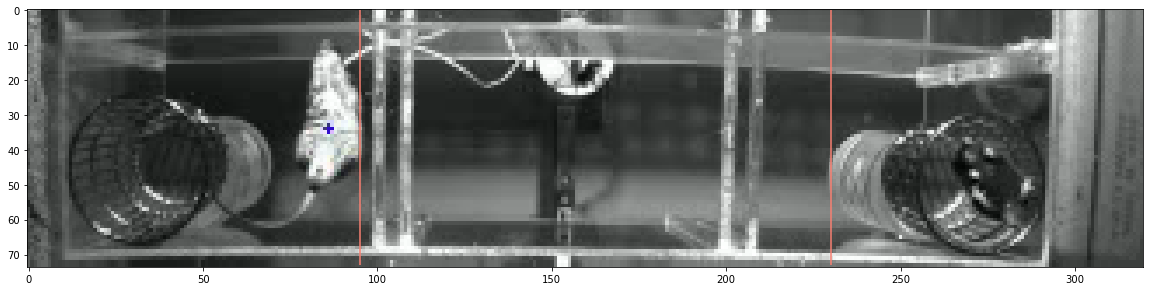

In [127]:
# examine behavior zones on example video:

#vid_fn = '/home/mmiller/Documents/data/astellas/fmr1ko_linear_social/April2020_FMR1_LinearSocial/behavior_2020-04-01-14-34-36_video_COM.mp4'
vid_fn = behavior_dir + vid_df.behav_data_basename.loc[vid_df.subject_ID==subj_ids[subj_id]].values[0]+'_COM.mp4'
print(subj_ids[subj_id])

vid = cv2.VideoCapture(vid_fn)
frame_height = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
frame_width = vid.get(cv2.CAP_PROP_FRAME_WIDTH)
vid.set(1, framei)
theframe = vid.read()[1]
#grayscale = transform.downscale_local_mean( cv2.cvtColor(theframe,cv2.COLOR_BGR2GRAY).astype('uint8'), (ds_fact,ds_fact)).astype('uint8')
vid.release()

f,ax = plt.subplots(1,1,figsize=(20,5))
ax.imshow(theframe,cmap='gray')
ax.vlines(x_threshs, ymin=0, ymax=frame_height-1, color='salmon')
plt.show()

### set test side for every video after examining sample frame:

In [33]:
#test_side=dict()
test_side[subj_ids[subj_id]] = 'l'
print(test_side)

{'OM047': 'l', 'OM045': 'r', 'OM038': 'l', 'OM051': 'r', 'OM042': 'l', 'OM040': 'r', 'OM035': 'l'}


In [36]:
pickle.dump(test_side,open('target_sides_20200415.pkl','wb'))

In [16]:
subj_ids = vid_df.subject_ID.values
print(subj_ids)

['OM047' 'OM045' 'OM038' 'OM051' 'OM042' 'OM040' 'OM035']


In [20]:
vid_df['novel_side'] = vid_df['subject_ID'].map(test_side)

In [21]:
vid_df

,subject_ID,genotype,data_dir_behavior,behav_data_basename,novel_side
12,OM047,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-11-37-35_video,l
13,OM045,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-12-15-55_video,r
14,OM038,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-13-22-44_video,l
15,OM051,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-14-02-40_video,r
16,OM042,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-14-41-15_video,l
17,OM040,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-15-21-57_video,r
18,OM035,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-16-29-32_video,l


### Occupancy analysis:

In [ ]:
## count l/r occupancy for each epoch for each subject:
epoch_times = [0, int(5*60*20), int(15*60*20)]
buffer_len = 30*20

occupancy_dict = dict()


for subj in np.unique(subj_ids):
    print(subj)
    com_fn = behavior_dir + vid_df.behav_data_basename.loc[vid_df.subject_ID==subj].values[0]+'_COM.csv'
    #print(com_fn)
    the_com = np.loadtxt(com_fn, delimiter=',')
    
    the_epochs = list(np.copy(epoch_times))
    the_epochs.append(len(the_com))
    epoch_segs = [[i+buffer_len, j-buffer_len] for i,j in zip(the_epochs[0:-1], the_epochs[1:])]
    
    occupancy_times = []
    for seg_i, seg in enumerate(epoch_segs):
        print(seg)
        left_time = int(sum(the_com[seg[0]:seg[1], 1] < x_threshs[0]))
        right_time = int(sum(the_com[seg[0]:seg[1], 1] > x_threshs[1]))
        #out_times[subj_i, seg_i, :] = [left_time, right_time]
        
        if seg_i == 0:
            occupancy_times.append([left_time, right_time])
            print('Habituation scores',left_time,right_time)        
        
        if seg_i == 1: 
            if vid_df.novel_side.loc[vid_df.subject_ID == subj].values == 'l': # correctly order times to map social target position to the right ([object, pref])
                occupancy_times.append([right_time, left_time])
                print('remap scores:', right_time,left_time)
            else:
                occupancy_times.append([left_time, right_time])      
                print('unmapped scores',left_time,right_time)
        if seg_i == 2: 
            if vid_df.novel_side.loc[vid_df.subject_ID == subj].values == 'l': # correctly order times to map novel target position to the right ([pref, novel])
                occupancy_times.append([left_time, right_time])
                print('unmapped scores:', left_time,right_time)
            else:
                occupancy_times.append([right_time, left_time])      
                print('remapped scores',right_time, left_time)

    occupancy_dict[subj] = occupancy_times
    print('\n')
    
#print(occupancy_dict)

In [ ]:
vid_df

In [ ]:
occupancy_dict

In [ ]:
## populated df with occupancy scores
habituation_times = {i:j[0] for i,j in zip(occupancy_dict.keys(), occupancy_dict.values())}
print(habituation_times)


pref_times = {i:occupancy_dict[i][1] for i in occupancy_dict}
print(pref_times)

novel_times = {i:occupancy_dict[i][2] for i in occupancy_dict}
print(novel_times)

vid_df['habituation_counts'] = vid_df['subject_ID'].map(habituation_times)
vid_df['pref_counts'] = vid_df['subject_ID'].map(pref_times)
vid_df['novel_counts'] = vid_df['subject_ID'].map(novel_times)

In [ ]:
vid_df

In [ ]:
print(vid_df.genotype.unique())

In [ ]:
## plot / test occupancy:

conds = vid_df.genotype.unique()
cmap = plt.get_cmap('tab10')
cdict = dict(zip(conds, [cmap(i) for i in np.linspace(0, 1 , len(conds))]))

f,ax = plt.subplots(1, 2, figsize = (20,5), sharey=True)

for the_condition,a in zip(conds,ax):
    the_subjs = vid_df.subject_ID.loc[vid_df.genotype == the_condition]

    for i in vid_df.habituation_counts.loc[vid_df.subject_ID.isin(the_subjs)]:
        a.plot([1, 1.1], [j/20 for j in i], 'o-', color = cdict[the_condition])
    for i in vid_df.pref_counts.loc[vid_df.subject_ID.isin(the_subjs)]:
        a.plot([1.2, 1.3], [j/20 for j in i], 'o-', color = cdict[the_condition])
    for i in vid_df.novel_counts.loc[vid_df.subject_ID.isin(the_subjs)]:
        a.plot([1.4, 1.5], [j/20 for j in i], 'o-', color = cdict[the_condition])
        

for a,cond in zip(ax,conds):
    a.set_title(cond)
    a.set_xticks([1, 1.1, 1.2, 1.3, 1.4, 1.5])
    a.set_xticklabels(['left', 'right', 'object', 'conspecific 1', 'conspecific 1', 'conspecific 2'], rotation = 345)
    a.set_ylim(0,500)
    a.set_yticks([0,250,500])
    a.set_ylabel('interaction time (s)')
    twoaxis(a)
plt.show()




### Locomotion analysis:

In [ ]:
com_fn = behavior_dir + vid_df.behav_data_basename.loc[vid_df.subject_ID==subj_ids[0]].values[0]+'_COM.csv'
the_com = np.loadtxt(com_fn, delimiter=',')

In [ ]:
print(the_com.shape)
print(np.diff(the_com).shape)
f,ax = plt.subplots(3,1,figsize=(10,6), sharex=True)
ax[0].plot(abs(np.diff(the_com[:,0])) + abs(np.diff(the_com[:,1])))
ax[1].plot(abs(np.diff(the_com)))
ax[2].plot(the_com[:,0])
ax[2].plot(the_com[:,1])

ax[0].set_xlim(3000,4000)

for a in ax:
    twoaxis(a)
plt.show()

In [ ]:
## distance traveled for each task section:
epoch_times = [0, int(5*60*20), int(15*60*20)]
buffer_len = 30*20

locomotion_dict = dict()


for subj in np.unique(subj_ids):
    print(subj)
    com_fn = behavior_dir + vid_df.behav_data_basename.loc[vid_df.subject_ID==subj].values[0]+'_COM.csv'
    #print(com_fn)
    the_com = np.loadtxt(com_fn, delimiter=',')
    
    the_epochs = list(np.copy(epoch_times))
    the_epochs.append(len(the_com))
    epoch_segs = [[i+buffer_len, j-buffer_len] for i,j in zip(the_epochs[0:-1], the_epochs[1:])]
    
    locomotion_list = []
    for seg_i, seg in enumerate(epoch_segs):
        #print(seg)
        #left_time = int(sum(the_com[seg[0]:seg[1], 1] < x_threshs[0]))
        #right_time = int(sum(the_com[seg[0]:seg[1], 1] > x_threshs[1]))
        pixels_traveled = sum(abs(np.diff(the_com[seg[0]:seg[1],0])) + abs(np.diff(the_com[seg[0]:seg[1],1])) ) 
        locomotion_list.append(pixels_traveled)
        #print(locomotion_list)
        
    locomotion_dict[subj] = locomotion_list
    print('\n')
    
print(locomotion_dict)

In [ ]:
vid_df

In [ ]:
vid_df['distance_traveled'] = vid_df['subject_ID'].map(locomotion_dict)

In [ ]:
vid_df

In [ ]:
f,ax = plt.subplots(1, 1, figsize = (6,6))

cmap = plt.get_cmap('tab10')
cdict = dict(zip(vid_df.genotype.unique(), [cmap(i) for i in np.arange(len(vid_df.genotype.unique()))]))
tick_list = []

for i in range(3):
    for gi, gtype in enumerate(vid_df.genotype.unique()):
        stat_vect = [stat[i] for stat in vid_df.distance_traveled.loc[vid_df.genotype == gtype]]
        ax.scatter(np.zeros_like(stat_vect) + (i*3) + gi , stat_vect, s=50, color=cdict[gtype], alpha=.5)
        ax.scatter( (i*3) + gi, np.median(stat_vect), s=1000, marker='_', color = cdict[gtype], linewidth = 4)
        tick_list.append((i*3) + gi)

ax.set_xticks(tick_list)
ax.set_xticklabels(['FMR1CTRL', 'FMR1KO'] * 3, rotation=315)
ax.set_ylim(0,15000)
ax.set_yticks([0,7500,15000])
ax.set_xlim(-1,8)
ax.set_title('Distance traveled')
#ax.grid('on', alpha=.5)
ax.set_ylabel('pixels')

twoaxis(ax)
plt.show()

### Social area restricted Ca activity analysis

In [22]:
print(subj_ids)
epoch_times = [0, int(5*60*20), int(15*60*20)]
buffer_len = 30*20

cmap = plt.get_cmap('tab10')

['OM047' 'OM045' 'OM038' 'OM051' 'OM042' 'OM040' 'OM035']


In [24]:
subj = subj_ids[-1]
com_fn = behavior_dir + vid_df.behav_data_basename.loc[vid_df.subject_ID==subj].values[0]+'_COM.csv'

the_com = np.loadtxt(com_fn, delimiter=',')

the_epochs = list(np.copy(epoch_times))
the_epochs.append(len(the_com))
epoch_segs = [[i+buffer_len, j-buffer_len] for i,j in zip(the_epochs[0:-1], the_epochs[1:])]

In [27]:
left_frames = np.argwhere(the_com[:,1] < x_threshs[0]).flatten()
right_frames = np.argwhere(the_com[:,1] > x_threshs[1]).flatten()

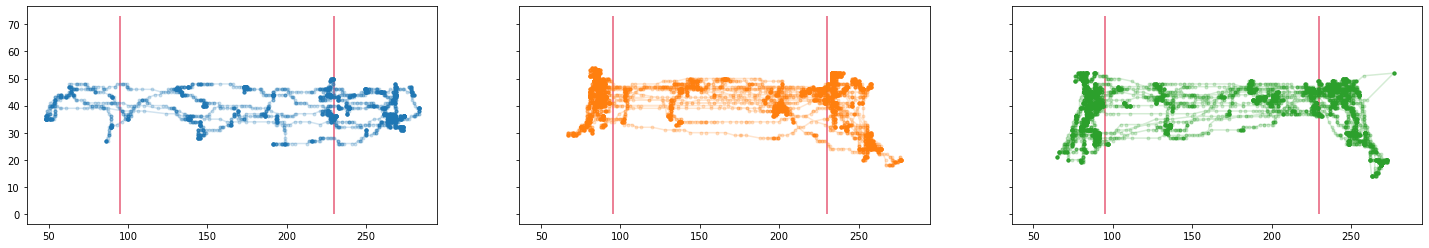

In [30]:
cmap = plt.get_cmap('tab10')

f,ax = plt.subplots(1,3,figsize=(25,4), sharex=True, sharey=True)

ax[0].plot(the_com[epoch_segs[0][0]:epoch_segs[0][1],1], the_com[epoch_segs[0][0]:epoch_segs[0][1],0], '-o', markersize=3, color=cmap(0), alpha=.2)

ax[1].plot(the_com[epoch_segs[1][0]:epoch_segs[1][1],1], the_com[epoch_segs[1][0]:epoch_segs[1][1],0], '-o', markersize=3, color=cmap(1), alpha=.2)

ax[2].plot(the_com[epoch_segs[2][0]:epoch_segs[2][1],1], the_com[epoch_segs[2][0]:epoch_segs[2][1],0], '-o', markersize=3, color=cmap(2), alpha=.2)

for a in ax:
    a.vlines(x_threshs, ymin=0, ymax=frame_height-1, color='crimson', alpha=.7)

plt.show()

### Load gpio and generate frame -> isxd time lookup:

In [31]:
log_df.head()

,date,subject_ID,genotype,virus,expression_time,brain_region,condition,data_dir_ca,isxd_data_basename,data_dir_behavior,behav_data_basename,Focus,Gain,LED,Comments,num_cells
0,20200302,OM025,PV,CaM6m_FLEXeNpHR,8 weeks,mPFC,enphr_stim,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-03-02-12-04-44_video,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20200302,OM025,PV,CaM6m_FLEXeNpHR,8 weeks,mPFC,enphr_stim,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-03-02-12-26-53_video,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20200302,OM025,PV,CaM6m_FLEXeNpHR,8 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-03-02-14-25-34_video,NaN,Behavior_2020-03-02-14-25-34_video,NaN,NaN,NaN,NaN,NaN
3,20200401,OM037,FMR1CTRL,CaM6m,5 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-04-01-14-34-36_video,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-01-14-34-36_video,660.0,6.8,0.2,num cells estimate is low due to blurry projec...,29.0
4,20200401,OM047,FMR1CTRL,CaM6m,5 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-04-01-15-19-03_video,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-01-15-19-03_video,610.0,6.4,0.4,lens insertion only 5 days ago,74.0


In [32]:
experiments = ['linear_social']
genotypes = ['FMR1CTRL', 'FMR1KO']
dates = ['20200408']

conditions = genotypes

In [33]:
df_sub = log_df.loc[(log_df.condition.isin(experiments)) & (log_df.genotype.isin(genotypes)) & (log_df.date.isin(dates)) ].copy()

In [34]:
print(df_sub.subject_ID.unique())

['OM047' 'OM045' 'OM038' 'OM051' 'OM042' 'OM040' 'OM035']


In [36]:
subj = df_sub.subject_ID.unique()[-1]
print(subj)

OM035


In [37]:
#print(get_cellset_paths(df_sub))
print(fix_data_path(df_sub.data_dir_ca.loc[df_sub.subject_ID == subj].values[0]))

/ariel/science/OM/Astellas/inscopix_imaging/April2020_FMR1_LinearSocial/20200408_repeat/20200408_OM035_CTRL/


In [38]:
cellsets = get_cellset_paths(df_sub)

In [39]:
print([i for i in cellsets if subj in i])

['/ariel/science/OM/Astellas/inscopix_imaging/April2020_FMR1_LinearSocial/20200408_repeat/20200408_OM035_CTRL/pipeline_OM035_2020-04-08-16-29-32_video-PP-MC/2020-04-08-16-29-32_video-PP-MC-bp-mc-dff-pcaica.isxd']


In [40]:
# load cellset and get timescale:
cs_fn = [i for i in cellsets if subj in i]

cs_time = (get_cellset_timescale(cs_fn[0]))
fs = round(1/cs_time[1], 6)
print(fs)
print(len(cs_time))

trace_mtx,_,_ = cellset_data_volumes(cs_fn[0])

20.015612
31445


/home/mmiller/Applications/idps/Inscopix Data Processing.linux/Contents/API/Python/isx/_internal.py:143: UserWarning: Converting from float64 to uint64.
  warnings.warn('Converting from {} to {}.'.format(array.dtype, dtype))


In [41]:
gpio_fn = fix_data_path(df_sub.data_dir_ca.loc[df_sub.subject_ID == subj].values[0])+'gpio.csv'

In [42]:
# Import GPIO csv file and extract sycn signal from sync channel:
sync_chan_name = ' GPIO-1' # note leading space

if os.path.isfile(gpio_fn):
    gpio = pd.read_csv(gpio_fn)
    sync_df = gpio.loc[gpio[' Channel Name'] == sync_chan_name]
    sync_df.reset_index(inplace=True, drop=True)
    sync_sub = sync_df[['Time (s)',' Value']]
else:
    print('{} file does not exist'.format(gpio_fn))

In [43]:
# detect pulse onsets and offsets:

offset = .072
offset = (35.334 - 35.279)
offset = 0

in_data = sync_df[' Value'].astype(np.float32)
in_time = sync_df['Time (s)'].astype(np.float32)

crossings = np.diff(1 * (in_data >  max(in_data)*.65) != 0 )

#in_pnts = np.arange(len(in_data))
#pulse_onsets = in_pnts[1:][crossings][0::2]
#pulse_offsets = in_pnts[1:][crossings][1::2]

pulse_onsets = in_time[1:][crossings].values[0::2]
pulse_offsets = in_time[1:][crossings].values[1::2]

start_t = pulse_onsets[0] - offset
#stopseg = min([num_frames, len(pulse_offsets)])
stop_t = pulse_onsets[-1] + (1/fs) - offset

print(pulse_onsets, '\n')
print(pulse_offsets)
print(start_t)
print(stop_t)

[   6.324    6.358    6.408 ... 1563.345 1563.395 1563.445] 

[   6.333    6.383    6.433 ... 1563.37  1563.42  1563.47 ]
6.323999881744385
1563.4949072895056


In [44]:
print(int(fs * max(cs_time)))
print(len(cs_time))

31443
31445


In [45]:
# create behavioral video frame lookup table and map to isxd timebase

#sync_times = np.zeros((int(fs * max(cs_time)), 1))
sync_times = np.zeros((len(cs_time), 1))
print(np.shape(sync_times))
ons_idx = ((pulse_onsets - offset) * fs).astype(int)
print(ons_idx)
print(max(cs_time)*fs)
sync_times[ons_idx] = 1
frame_lookup = np.cumsum(sync_times).astype(int)
print(max(frame_lookup))


(31445, 1)
[  126   127   128 ... 31291 31292 31293]
31443.99972115461
31137


In [46]:
print(frame_lookup)
print(len(frame_lookup))
print(len(trace_mtx))
print(np.argmax(frame_lookup))
frame_lookup[np.argmax(frame_lookup)+1:] = 0

[    0     0     0 ... 31137 31137 31137]
31445
31445
31293


In [49]:
z_mtx = stats.zscore(trace_mtx, axis = 1, nan_policy = 'omit')
z_mtx_sub = z_mtx.copy()

for idx,i in enumerate(z_mtx.transpose()):
    z_mtx_sub[:,idx] = i - np.min(i)

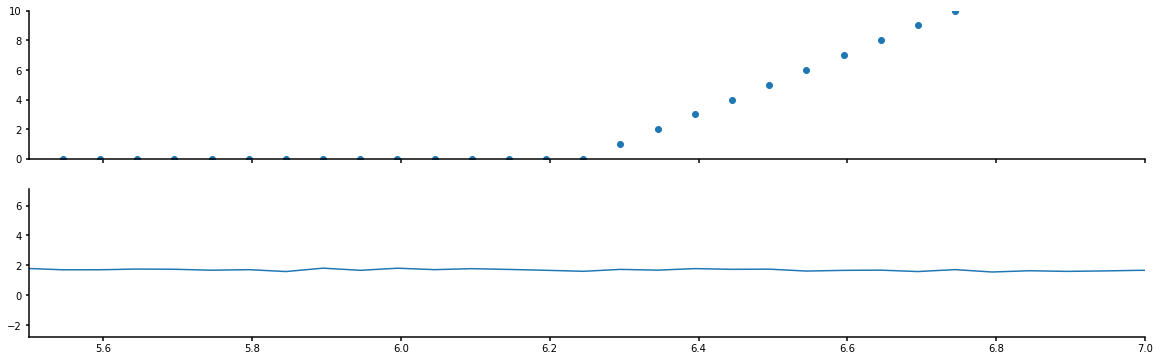

In [50]:
f,ax = plt.subplots(2,1,figsize=(20,6), sharex=True)
ax[0].plot(cs_time,frame_lookup,'o')
ax[0].plot(cs_time[30737],frame_lookup[30737],'ro')

ax[1].plot(cs_time, z_mtx[:,15])

ax[0].set_xlim(5.5, 7)
ax[0].set_ylim(0,10)

#ax[1].set_ylim(-100,100)

for a in ax:
    twoaxis(a)
plt.show()

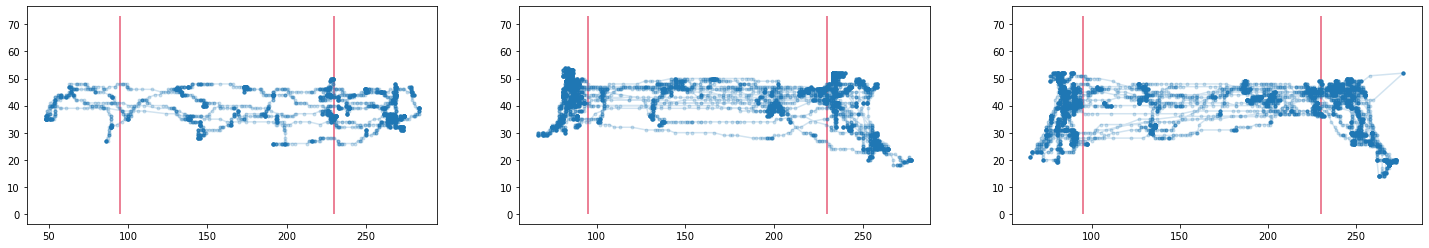

In [51]:
f,ax = plt.subplots(1,3,figsize=(25,4))

ax[0].plot(the_com[epoch_segs[0][0]:epoch_segs[0][1],1], the_com[epoch_segs[0][0]:epoch_segs[0][1],0], '-o', markersize=3, alpha=.2)

ax[1].plot(the_com[epoch_segs[1][0]:epoch_segs[1][1],1], the_com[epoch_segs[1][0]:epoch_segs[1][1],0], '-o', markersize=3, alpha=.2)

ax[2].plot(the_com[epoch_segs[2][0]:epoch_segs[2][1],1], the_com[epoch_segs[2][0]:epoch_segs[2][1],0], '-o', markersize=3, alpha=.2)

for a in ax:
    a.vlines(x_threshs, ymin=0, ymax=frame_height-1, color='crimson', alpha=.7)

plt.show()

In [52]:
print(len(the_com))
print(max(frame_lookup))

31143
31137


In [93]:
def make_frame_lookup(gpio_csv_fn, cellset_fn, sync_chan_name = ' GPIO-1', offset = 0, pulse_thresh =0.55):
    #
    #
    #
    
    cs_time = (get_cellset_timescale(cellset_fn))
    fs = round(1/cs_time[1], 8)

    if os.path.isfile(gpio_fn):
        gpio = pd.read_csv(gpio_fn)
        sync_df = gpio.loc[gpio[' Channel Name'] == sync_chan_name]
        sync_df.reset_index(inplace=True, drop=True)
        sync_sub = sync_df[['Time (s)',' Value']]
    else:
        print('{} file does not exist'.format(gpio_fn))
        
    
    # detect pulse onsets and offsets in gpio:
    in_data = sync_df[' Value'].astype(np.float32)
    in_time = sync_df['Time (s)'].astype(np.float32)

    crossings = np.diff(1 * (in_data >  max(in_data) * pulse_thresh) != 0 )

    pulse_onsets = in_time[1:][crossings].values[0::2]
    pulse_offsets = in_time[1:][crossings].values[1::2]

    start_t = pulse_onsets[0] - offset
    stop_t = pulse_onsets[-1] + (1/fs) - offset
    
    # create behavioral video frame lookup table and map to isxd timebase:
    sync_times = np.zeros((len(cs_time), 1))
    ons_idx = ((pulse_onsets - offset) * fs).astype(int)
    sync_times[ons_idx] = 1
    frame_lookup = np.cumsum(sync_times).astype(int)
    frame_lookup[np.argmax(frame_lookup)+1:] = 0
    
    return frame_lookup

### Color / scale COM trace by cell's z-score:

In [83]:
cellnum = np.random.choice(z_mtx_sub.shape[1])
print(cellnum)
cellnum = 32

frame_win = int(fs * .05)
the_cmap = plt.get_cmap('PuBu')

cvect = []
svect = []
for i in np.arange(1,max(frame_lookup)):
    x_start = int(fs * cs_time[np.argwhere(frame_lookup==i).flatten()[0]])
    #cvect.append(cmap(np.mean(z_mtx[x_start:(x_start + frame_win), cellnum])))
    svect.append(np.mean(z_mtx[x_start:(x_start + frame_win), cellnum]))
svect = np.asarray(svect)

57


In [84]:
print(np.shape(the_cmap(svect)))
cvect = the_cmap(svect)

(31136, 4)


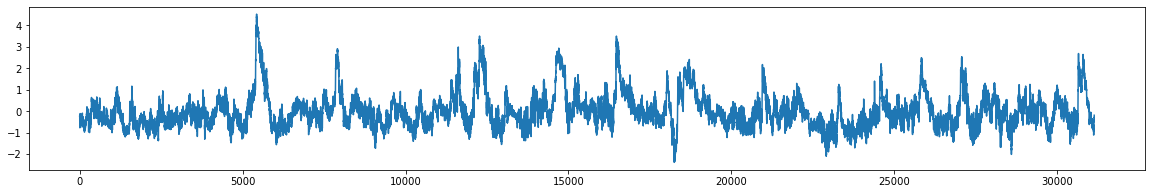

In [85]:
f,ax = plt.subplots(1,1,figsize=(20,3))
ax.plot(svect)
plt.show()

In [157]:
print(len(svect))
print(cs_time[np.argmax(frame_lookup)])
print(cs_time[np.argwhere(frame_lookup==1).flatten()[0]])

31136
1543.944783
8.293526


In [86]:
print(test_side[subj])

l


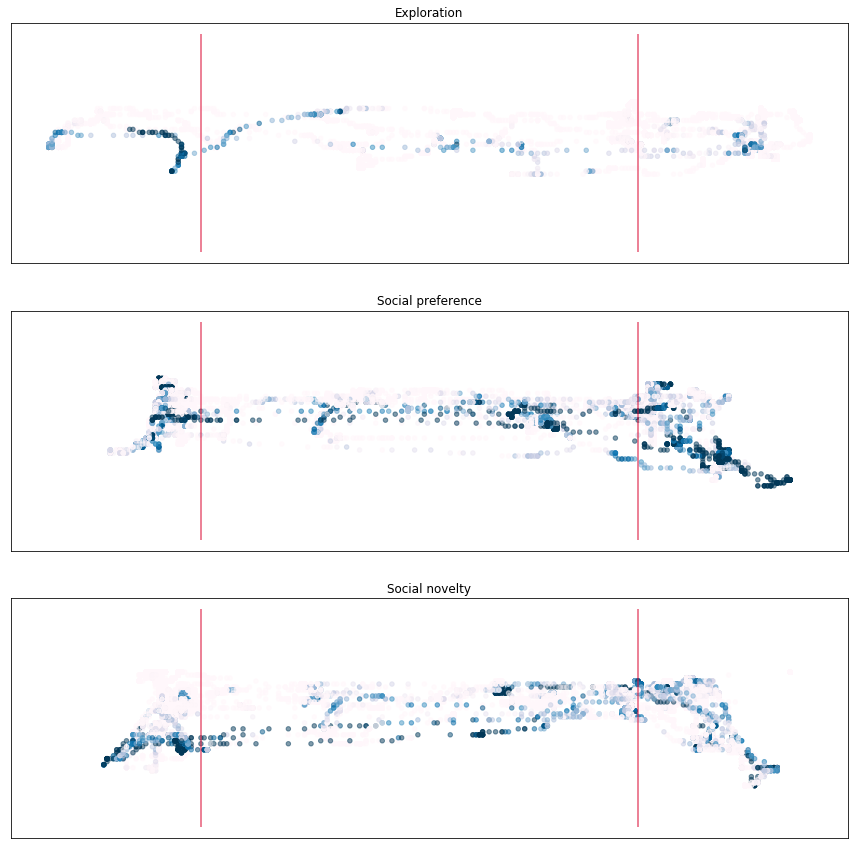

In [87]:
titles = ['Exploration', 'Social preference', 'Social novelty']

f,ax = plt.subplots(3,1,figsize=(15,15), sharex=True, sharey=True)

ax[0].scatter(the_com[epoch_segs[0][0]:epoch_segs[0][1],1], the_com[epoch_segs[0][0]:epoch_segs[0][1],0], s=20, alpha=.5, c=cvect[epoch_segs[0][0]: epoch_segs[0][1]])

ax[1].scatter(the_com[epoch_segs[1][0]:epoch_segs[1][1],1], the_com[epoch_segs[1][0]:epoch_segs[1][1],0], s=20, alpha=.5, c=cvect[epoch_segs[1][0]: epoch_segs[1][1]])

ax[2].scatter(the_com[epoch_segs[2][0]:epoch_segs[2][1],1], the_com[epoch_segs[2][0]:epoch_segs[2][1],0], s=20, alpha=.5, c=cvect[epoch_segs[2][0]: epoch_segs[2][1]])

for a,t in zip(ax, titles):
    a.vlines(x_threshs, ymin=0, ymax=frame_height-1, color='crimson', alpha=.7)
    a.set_yticks([])
    a.set_xticks([])
    a.set_title(t)
plt.show()

/home/mmiller/Applications/anaconda3/envs/isxenv/lib/python3.6/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


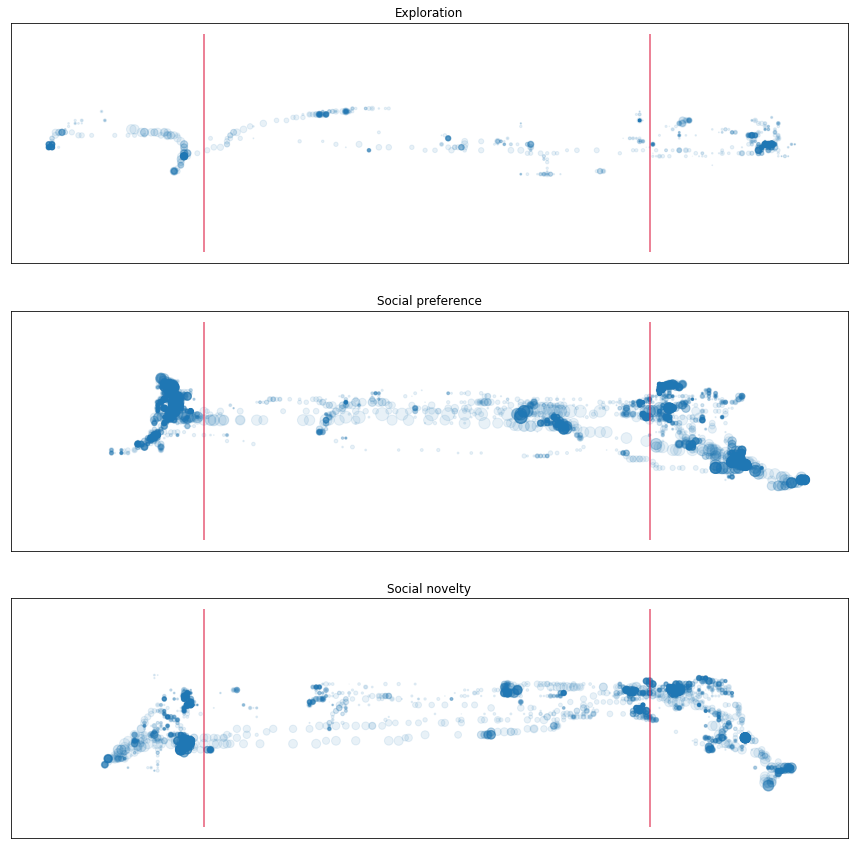

In [88]:
titles = ['Exploration', 'Social preference', 'Social novelty']

f,ax = plt.subplots(3,1,figsize=(15,15), sharex=True, sharey=True)

ax[0].scatter(the_com[epoch_segs[0][0]:epoch_segs[0][1],1], the_com[epoch_segs[0][0]:epoch_segs[0][1],0], s=50*svect[epoch_segs[0][0]: epoch_segs[0][1]], alpha=.1)

ax[1].scatter(the_com[epoch_segs[1][0]:epoch_segs[1][1],1], the_com[epoch_segs[1][0]:epoch_segs[1][1],0], s=50*svect[epoch_segs[1][0]: epoch_segs[1][1]], alpha=.1)

ax[2].scatter(the_com[epoch_segs[2][0]:epoch_segs[2][1],1], the_com[epoch_segs[2][0]:epoch_segs[2][1],0], s=50*svect[epoch_segs[2][0]: epoch_segs[2][1]], alpha=.1)

for a,t in zip(ax, titles):
    a.vlines(x_threshs, ymin=0, ymax=frame_height-1, color='crimson', alpha=.7)
    a.set_yticks([])
    a.set_xticks([])
    a.set_title(t)
plt.show()

In [95]:
df_sub.head()

,date,subject_ID,genotype,virus,expression_time,brain_region,condition,data_dir_ca,isxd_data_basename,data_dir_behavior,behav_data_basename,Focus,Gain,LED,Comments,num_cells
12,20200408,OM047,FMR1CTRL,CaM6m,6 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-04-08-11-37-35_video,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-11-37-35_video,490.0,4.6,0.3,Very different efocus,139.0
13,20200408,OM045,FMR1KO,CaM6m,6 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-04-08-12-15-55_video,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-12-15-55_video,660.0,1.8,0.2,NaN,155.0
14,20200408,OM038,FMR1KO,CaM6m,6 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-04-08-13-22-44_video,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-13-22-44_video,400.0,4.6,0.2,NaN,275.0
15,20200408,OM051,FMR1CTRL,CaM6m,6 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-04-08-14-02-40_video,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-14-02-40_video,320.0,5.2,0.4,Very different efocus,404.0
16,20200408,OM042,FMR1KO,CaM6m,6 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-04-08-14-41-15_video,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-08-14-41-15_video,1000.0,2.4,0.2,NaN,175.0


### Summary analysis based on COM:

In [171]:
the_date = [20200408]

epoch_times = [(0,5), (5,15), (15,25)]

x_threshs = [95, 230] # these reflect pixels from 4x downsampled video


In [96]:
print(conditions)

['FMR1CTRL', 'FMR1KO']


In [216]:
print(max(right_epoch_frames))
print(max(left_epoch_frames))
print(sub_z_mtx.shape)
print(np.nanmean(sub_z_mtx[left_epoch_frames, :], axis=0).shape)
print(np.mean(sub_z_mtx[right_epoch_frames, :], axis=0).shape)

31602
30239
(31602, 39)
(39,)


IndexError: index 31602 is out of bounds for axis 0 with size 31602

In [190]:
# initialize stat dict:
stats_to_do = ['left trace amplitude', 'right trace amplitude']
epoch_names = ['exploration', 'social_preference', 'social_novelty']
stat_dict = dict()
for c in conditions:
    stat_dict[c] = {}
    for e in epoch_names:
        stat_dict[c][e] = {}
        for s in stats_to_do:
            stat_dict[c][e][s] = []
#stat_dict = dict(keys=conditions)

In [221]:
for the_cond in conditions:
    print('\n\n',the_cond)
    df_cond = df_sub.loc[(df_sub.date.isin(the_date)) & (df_sub.genotype == the_cond)] 
    cellsets_cond = get_cellset_paths(df_cond) # collect paths to cellsets of interest
    subj_ids = df_cond.subject_ID.unique()
    for subj in subj_ids[:1]: # each subject:
        print('\n',subj)
        # Load cellset and gpio csv file, use them to create frame-lookup vector:
        subj_ca_path = fix_data_path(df_cond.data_dir_ca.loc[df_cond.subject_ID == subj].values[0] )
        subj_behav_path = fix_data_path(df_cond.data_dir_behavior.loc[df_cond.subject_ID == subj].values[0])
        gpio_fn = [subj_ca_path + i for i in os.listdir(subj_ca_path) if 'gpio.csv' in i][0]
        cellset_fn = [i for i in cellsets_cond if subj in i][0]
        frame_lookup = make_frame_lookup(gpio_fn, cellset_fn)
        cs_time = (get_cellset_timescale(cellset_fn))
        cs_fs = round(1/(cs_time[1]) ,8)
        print('Ca imaging sampling rate: {}'.format(cs_fs))
        
        # Load COM csv file:
        com_fn = behavior_dir + df_cond.behav_data_basename.loc[df_cond.subject_ID == subj].values[0] + '_COM.csv'
        the_com = np.loadtxt(com_fn, delimiter=',')
        
        # flip Center of mass x-values if test side is on the right. This aligns all data so that test side = left
        the_test_side = test_side[subj]
        print('test side: {}'.format(the_test_side))
        if the_test_side == 'r': 
            the_com[:,1] = -(the_com[:,1] - frame_width )
        
        # identify frames for which COM exceeded left or right threshold:
        left_frames = np.argwhere(the_com[:,1] < x_threshs[0]).flatten()
        right_frames = np.argwhere(the_com[:,1] > x_threshs[1]).flatten()
        print(max(left_frames))
        print(max(right_frames))
        
        # Build trace_matrix / z-matrix, event-matrix, etc:
        [the_trace_mtx, _,_,] = cellset_data_volumes(cellset_fn, isx_ed_threshold=3,autosort_snr=4)
        z_mtx = stats.zscore(the_trace_mtx, axis = 1, nan_policy = 'omit')
        
        # Make time-base for frame-averaged activity. Each time point references the start of a behavior video frame:
        tvect = []
        for i in np.arange(1,max(frame_lookup)):
            x_start = cs_time[np.argwhere(frame_lookup==i).flatten()[0]]
            tvect.append(x_start)
        tvect = np.asarray(tvect)
        behav_fs = 1/(max(tvect) / len(frame_lookup))
        
        # extract activity for each video frame and assemble into matrix:
        frame_win = int(cs_fs * .05)
        
        sub_z_mtx = np.zeros((len(tvect), z_mtx.shape[1]))
        print('Building frame-aligned trace matrix...')
        for cellnum in range(z_mtx.shape[1]):
            svect = []
            for i in np.arange(1,max(frame_lookup)):
                x_start = int(fs * cs_time[np.argwhere(frame_lookup==i).flatten()[0]])
                svect.append(np.mean(z_mtx[x_start:(x_start + frame_win), cellnum]))
            svect = np.asarray(svect)
            sub_z_mtx[:,cellnum] = svect
        #print(sub_z_mtx.shape)
        
        
        
        for the_epoch, the_epoch_name in zip(epoch_times, epoch_names): # each behavior epoch:     
            # trace z-score:
            
            left_epoch_frames = np.intersect1d(left_frames[left_frames > (the_epoch[0]*60*behav_fs)], left_frames[left_frames < (the_epoch[1]*60*behav_fs)])
            right_epoch_frames = np.intersect1d(right_frames[right_frames > (the_epoch[0]*60*behav_fs)], right_frames[right_frames < (the_epoch[1]*60*behav_fs)])
            
            left_zscores = np.nanmean(sub_z_mtx[left_epoch_frames-1 ,:], axis=1)
            right_zscores = np.nanmean(sub_z_mtx[right_epoch_frames-1 ,:], axis=1)
            stat_dict[the_cond][the_epoch_name]['left trace amplitude'].append(left_zscores)
            stat_dict[the_cond][the_epoch_name]['right trace amplitude'].append(right_zscores)
            

            
            
#            rate_mtx = np.nansum(the_raster_isx_mtx[int(the_epoch[0]*60*fs) : int(the_epoch[1]*60*fs)],axis=0) / ((the_epoch[1]-the_epoch[0])*60)
#            print('\t\tavg event rate: {} events/second'.format(round(np.mean(rate_mtx),4)))
#            stat_dict[the_cond][the_epoch_name]['event_rate'].append(rate_mtx)

            # weighted event rate:
#            peak_mtx = the_trace_mtx * the_raster_isx_mtx
#            weighted_rate_mtx = np.nansum(peak_mtx[int(the_epoch[0]*60*fs) : int(the_epoch[1]*60*fs)],axis=0) / ((the_epoch[1]-the_epoch[0])*60)
            #print('\t\tavg weighted event rate: {} sig/second'.format(round(np.mean(weighted_rate_mtx),4)))
#            stat_dict[the_cond][the_epoch_name]['weighted_event_rate'].append(weighted_rate_mtx)
            # fraction of cells active:




 FMR1CTRL

 OM047
Ca imaging sampling rate: 20.01561218
test side: l
30239
31602


/home/mmiller/Applications/idps/Inscopix Data Processing.linux/Contents/API/Python/isx/_internal.py:143: UserWarning: Converting from float64 to uint64.
  warnings.warn('Converting from {} to {}.'.format(array.dtype, dtype))


Building frame-aligned trace matrix...
(0, 5)
101.24479660140778 235.80815506184888
0.049581193242609095 299.96621911778504
(5, 15)
328.6737300052557 848.6317035404974
300.01580031102765 899.9978197398403
(15, 25)
907.4349987262317 1499.2857024632565
900.0474009330829 1487.9811904039416


 FMR1KO

 OM045
Ca imaging sampling rate: 20.01561218
test side: r
30747
31034
Building frame-aligned trace matrix...
(0, 5)
0.3478555511705686 299.9508724093646
8.199452277591973 258.65544912040133
(5, 15)
300.00056605953176 899.9520045284281
312.07612305016727 891.702858600669
(15, 25)
900.0016981785953 1499.9531366474916
917.5435566876255 1492.697863723077
